In [1]:
!pip install kaggle
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
!unzip imdb-dataset-of-50k-movie-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 35% 9.00M/25.7M [00:00<00:00, 93.2MB/s]
100% 25.7M/25.7M [00:00<00:00, 175MB/s] 
Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [2]:
!ls

'IMDB Dataset.csv'   imdb-dataset-of-50k-movie-reviews.zip   sample_data


In [3]:
import nltk
import numpy as np
import pandas as pd
import re
import string
from bs4 import BeautifulSoup
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer

from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [4]:
df = pd.read_csv('IMDB Dataset.csv')

# Set of English stop words
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [5]:
df.head(3)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive


In [6]:
def nettoyer_texte(texte):
    texte = BeautifulSoup(texte, "html.parser").get_text()

    texte = re.sub(f"[{string.punctuation}]", " ", texte)

    texte = texte.lower()

    mots = texte.split()
    mots = [mot for mot in mots if mot not in stop_words]
    texte = " ".join(mots)

    texte = ' '.join([lemmatizer.lemmatize(word) for word in texte.split() if len(word) > 2])  # Lemmatize and remove short words

    return texte

In [7]:
df['review'] = df['review'].apply(nettoyer_texte)

<ipython-input-6-e139fbbd64af>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  texte = BeautifulSoup(texte, "html.parser").get_text()


In [8]:
# Tokenize the reviews
tokenized_reviews = df["review"].apply(nltk.word_tokenize)
df["tokenized_reviews"] = tokenized_reviews

# Tokenizer and sequence padding
tokenizer = Tokenizer(num_words=5000)  # Limit the vocabulary size
tokenizer.fit_on_texts(tokenized_reviews)
sequences = tokenizer.texts_to_sequences(tokenized_reviews)
X = pad_sequences(sequences, maxlen=500)

In [9]:
# Label encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["sentiment"])

In [10]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)


In [11]:

# Early stopping and learning rate decay
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-5)

In [12]:
# Build LSTM model
vocab_size = min(tokenizer.num_words, len(tokenizer.word_index)) + 1  # Use num_words from tokenizer
print(vocab_size)

model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=500),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Fit the model
model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, callbacks=[early_stopping, reduce_lr])


5001
Epoch 1/10
1250/1250 [==============================] - 108s 82ms/step - loss: 0.3803 - accuracy: 0.8329 - val_loss: 0.3048 - val_accuracy: 0.8709 - lr: 0.0010
Epoch 2/10
1250/1250 [==============================] - 55s 44ms/step - loss: 0.2778 - accuracy: 0.8879 - val_loss: 0.3144 - val_accuracy: 0.8718 - lr: 0.0010
Epoch 3/10
1250/1250 [==============================] - 51s 41ms/step - loss: 0.2351 - accuracy: 0.9086 - val_loss: 0.3037 - val_accuracy: 0.8753 - lr: 0.0010
Epoch 4/10
1250/1250 [==============================] - 47s 38ms/step - loss: 0.2012 - accuracy: 0.9240 - val_loss: 0.3033 - val_accuracy: 0.8778 - lr: 0.0010
Epoch 5/10
1250/1250 [==============================] - 48s 38ms/step - loss: 0.1726 - accuracy: 0.9357 - val_loss: 0.3329 - val_accuracy: 0.8747 - lr: 0.0010
Epoch 6/10
1250/1250 [==============================] - 47s 38ms/step - loss: 0.1409 - accuracy: 0.9492 - val_loss: 0.3792 - val_accuracy: 0.8742 - lr: 0.0010
Epoch 7/10
1250/1250 [==================

313/313 [==============================] - 8s 20ms/step
Accuracy: 0.8649
Precision: 0.8551683862176368
Recall: 0.8786
F1-score: 0.8667258557758706
Sensitivity: 0.5137
Specificity: 0.4863


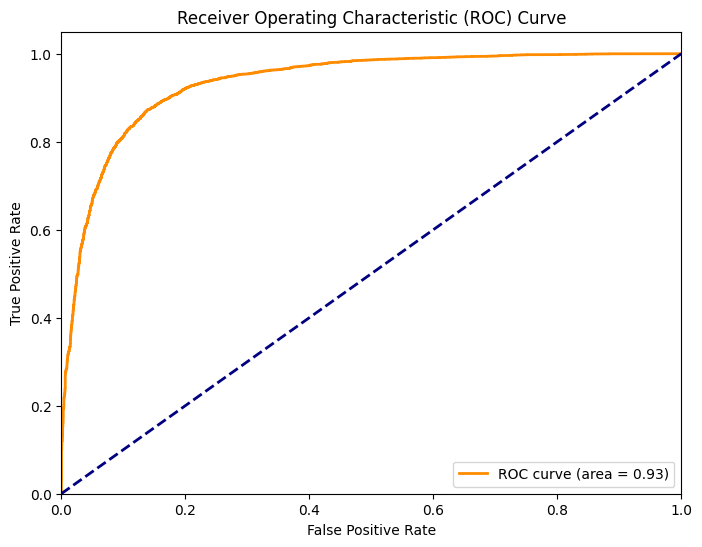

In [13]:
# Generate predictions
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred_prob = model_lstm.predict(X_test)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# Accuracy
accuracy = accuracy_score(y_test, y_pred_classes)

# Precision
precision = precision_score(y_test, y_pred_classes)

# Recall
recall = recall_score(y_test, y_pred_classes)

# F1-score
f1 = f1_score(y_test, y_pred_classes)

# True Positives, True Negatives, False Positives, False Negatives
tp = np.sum((y_test == 1) & (y_pred_classes == 1))
tn = np.sum((y_test == 0) & (y_pred_classes == 0))
fp = np.sum((y_test == 0) & (y_pred_classes == 1))
fn = np.sum((y_test == 1) & (y_pred_classes == 0))

# Sensitivity (True Positive Rate)
sensitivity = tp / (tp + fn)

# Specificity (True Negative Rate)
specificity = tn / (tn + fp)

# Print performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()